As of now this is just a bit of a sandbox to organize my thoughts for what to include in the project.

Just loading the data here.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

# combining data for cross validation
df_full = pd.concat([df_train, df_test])

Data cleanup

In [29]:
# drop unnamed index column
df_train.drop("Unnamed: 0", axis = 1, inplace=True)
df_test.drop("Unnamed: 0", axis = 1, inplace=True)
df_full.drop("Unnamed: 0", axis = 1, inplace=True)

# drop id column
df_train.drop("id", axis = 1, inplace=True)
df_test.drop("id", axis = 1, inplace=True)
df_full.drop("id", axis = 1, inplace=True)

df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_full.replace([np.inf, -np.inf], np.nan, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_full.dropna(inplace=True)

Let's encode all the categorical data as integers. Quick and dirty method, just use the index of the column value as the integer value. We'll also do some basic processing of the data here, like splitting the data into train and test, x and y.

This is one method for encoding the categorical values into integers (as opposed to one-hot encoding) and the choice comes with implications for the data. ELABORATE ON THIS?

In [30]:
from sklearn.preprocessing import StandardScaler

genders = df_train['Gender'].unique()
customer_types = df_train['Customer Type'].unique()
travel_type = df_train['Type of Travel'].unique()
travel_class = df_train['Class'].unique()
satisfaction = df_train['satisfaction'].unique()

def get_index_value_from_list(data_list, value):
    """
    """
    if value is None:
      print("returning none")
      return None
    res = np.where((data_list == value))[0]
    #if len(res) == 0:
    #  return None
    if res.size == 0:
      print(f"Returning None")
      return None
    return res[0]

def transform_gender(x):
    res = get_index_value_from_list(genders, x)
    return res

def transform_customer_type(x):
    return get_index_value_from_list(customer_types, x)

def transform_travel_type(x):
    return get_index_value_from_list(travel_type, x)
    
def transform_class(x):
    return get_index_value_from_list(travel_class, x)

def transform_satisfaction(x):
    return get_index_value_from_list(satisfaction, x)
    
def process_data(df):
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    
    return df

df_train = process_data(df_train)
df_test = process_data(df_test)

scaler = StandardScaler()

df_train['Arrival Delay in Minutes'].fillna(df_train['Arrival Delay in Minutes'].median(), inplace = True)
df_test['Arrival Delay in Minutes'].fillna(df_train['Arrival Delay in Minutes'].median(), inplace = True)

df_train_x = df_train.drop('satisfaction',axis=1)
#df_train_x.fillna(0)
#df_train_x.dropna()

df_test_x = df_test.drop('satisfaction',axis=1)
#df_test_x.fillna(0)
#df_test_x.dropna()

df_train_y = df_train['satisfaction']
#df_train_y.fillna(0)

df_test_y = df_test['satisfaction']
#df_test_y.fillna(0)

x_train = scaler.fit_transform(df_train_x)
x_test = scaler.fit_transform(df_test_x)


In [31]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

#df_full = pd.concat([df_train, df_test])
df_full = process_data(df_full)

df_full['Arrival Delay in Minutes'].fillna(df_full['Arrival Delay in Minutes'].median(), inplace = True)

df_full_x = df_full.drop('satisfaction',axis=1)
df_full_y = df_full['satisfaction']

pca = PCA(n_components=2)
pca.fit(df_full_x)
x_train_full = scaler.fit_transform(df_full_x)
k = 10 
kf = KFold(n_splits=k, shuffle=True, random_state=1)
model = LogisticRegression()
scores = cross_val_score(model, x_train_full, df_full_y, cv=kf)
print(scores)
print(f"Accuracy: {np.mean(scores), np.std(scores)}")
model = LogisticRegression()
model.fit(x_train, df_train_y)
y_pred = model.predict(x_test)
accuracy_score(df_test_y, y_pred)

[0.87049193 0.86941077 0.87296316 0.87358097 0.87412155 0.87381265
 0.8739671  0.87527031 0.87117702 0.87148594]
Accuracy: (0.8726281406538847, 0.001781926906117256)


0.870466921561812

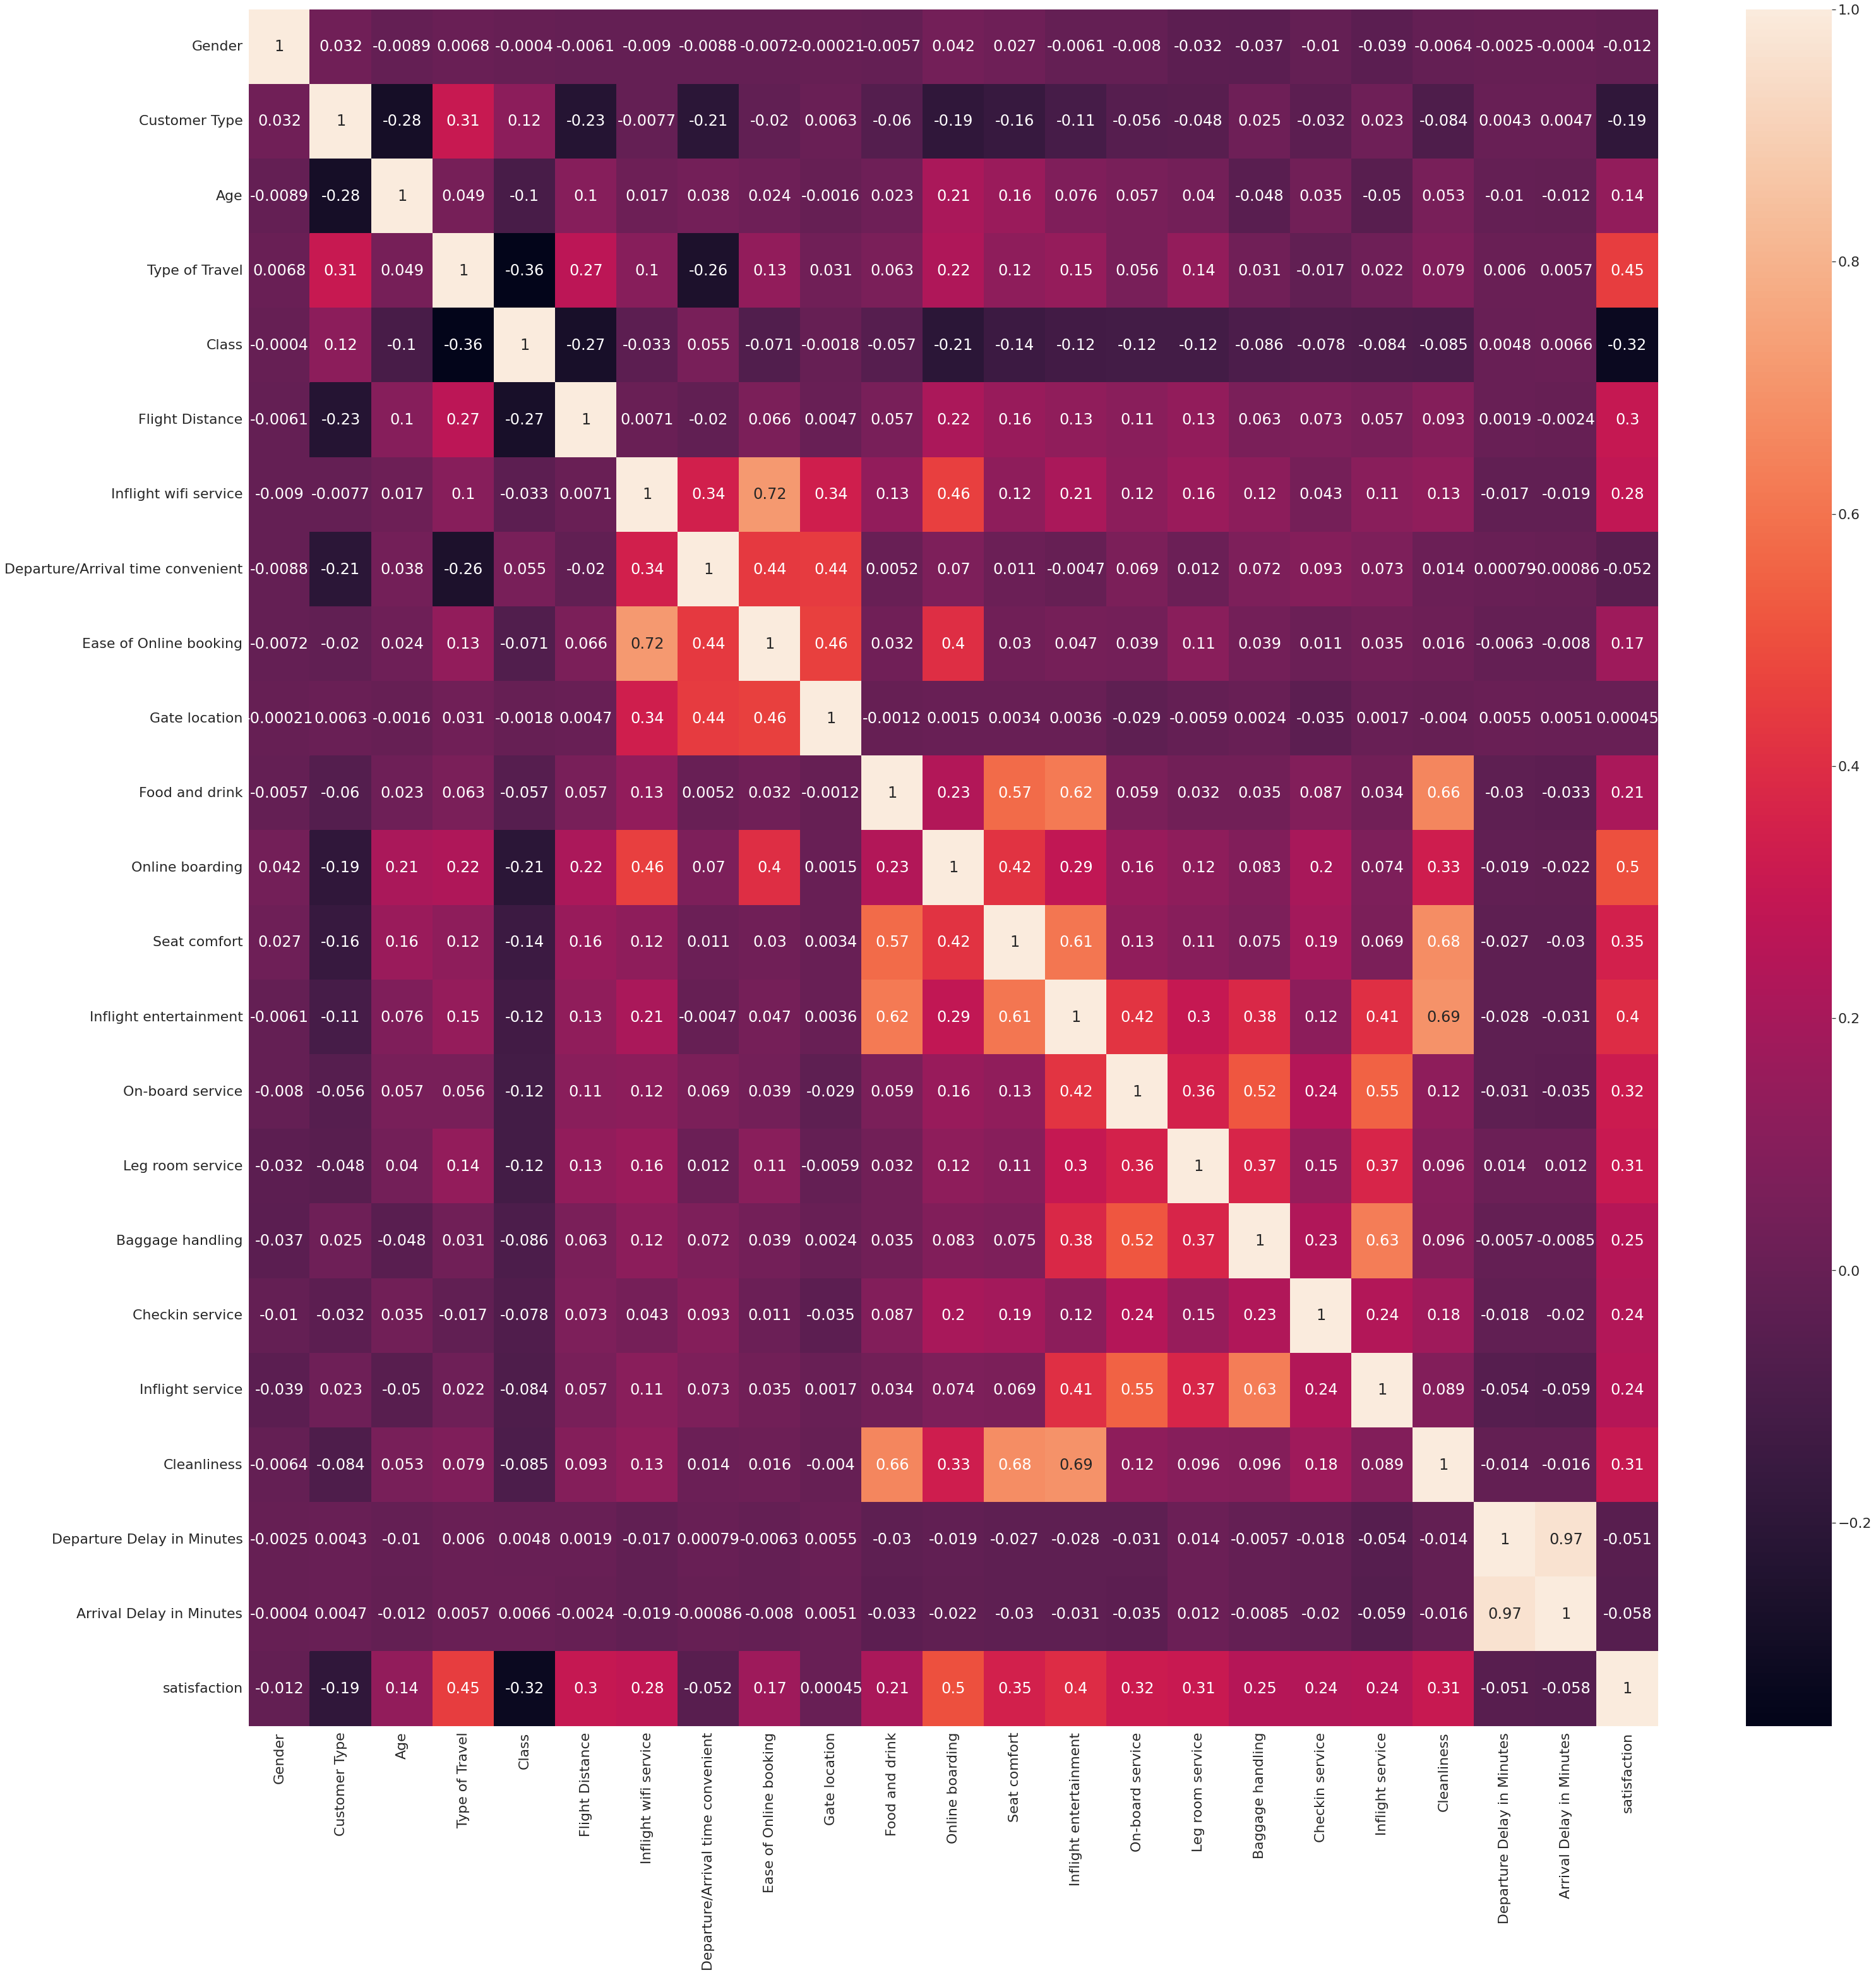

In [32]:
import seaborn as sns
sns.set(font_scale=2)
corr = df_train.corr()
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(corr, annot=True)
corr_list = []
#for col in df_train:
#  print(sum(corr[col]))
col = df_train.columns[22]
#print(corr[col])
#print(sum(corr[col]))
#print(type(corr[col]))
#print(corr.get('x',0))

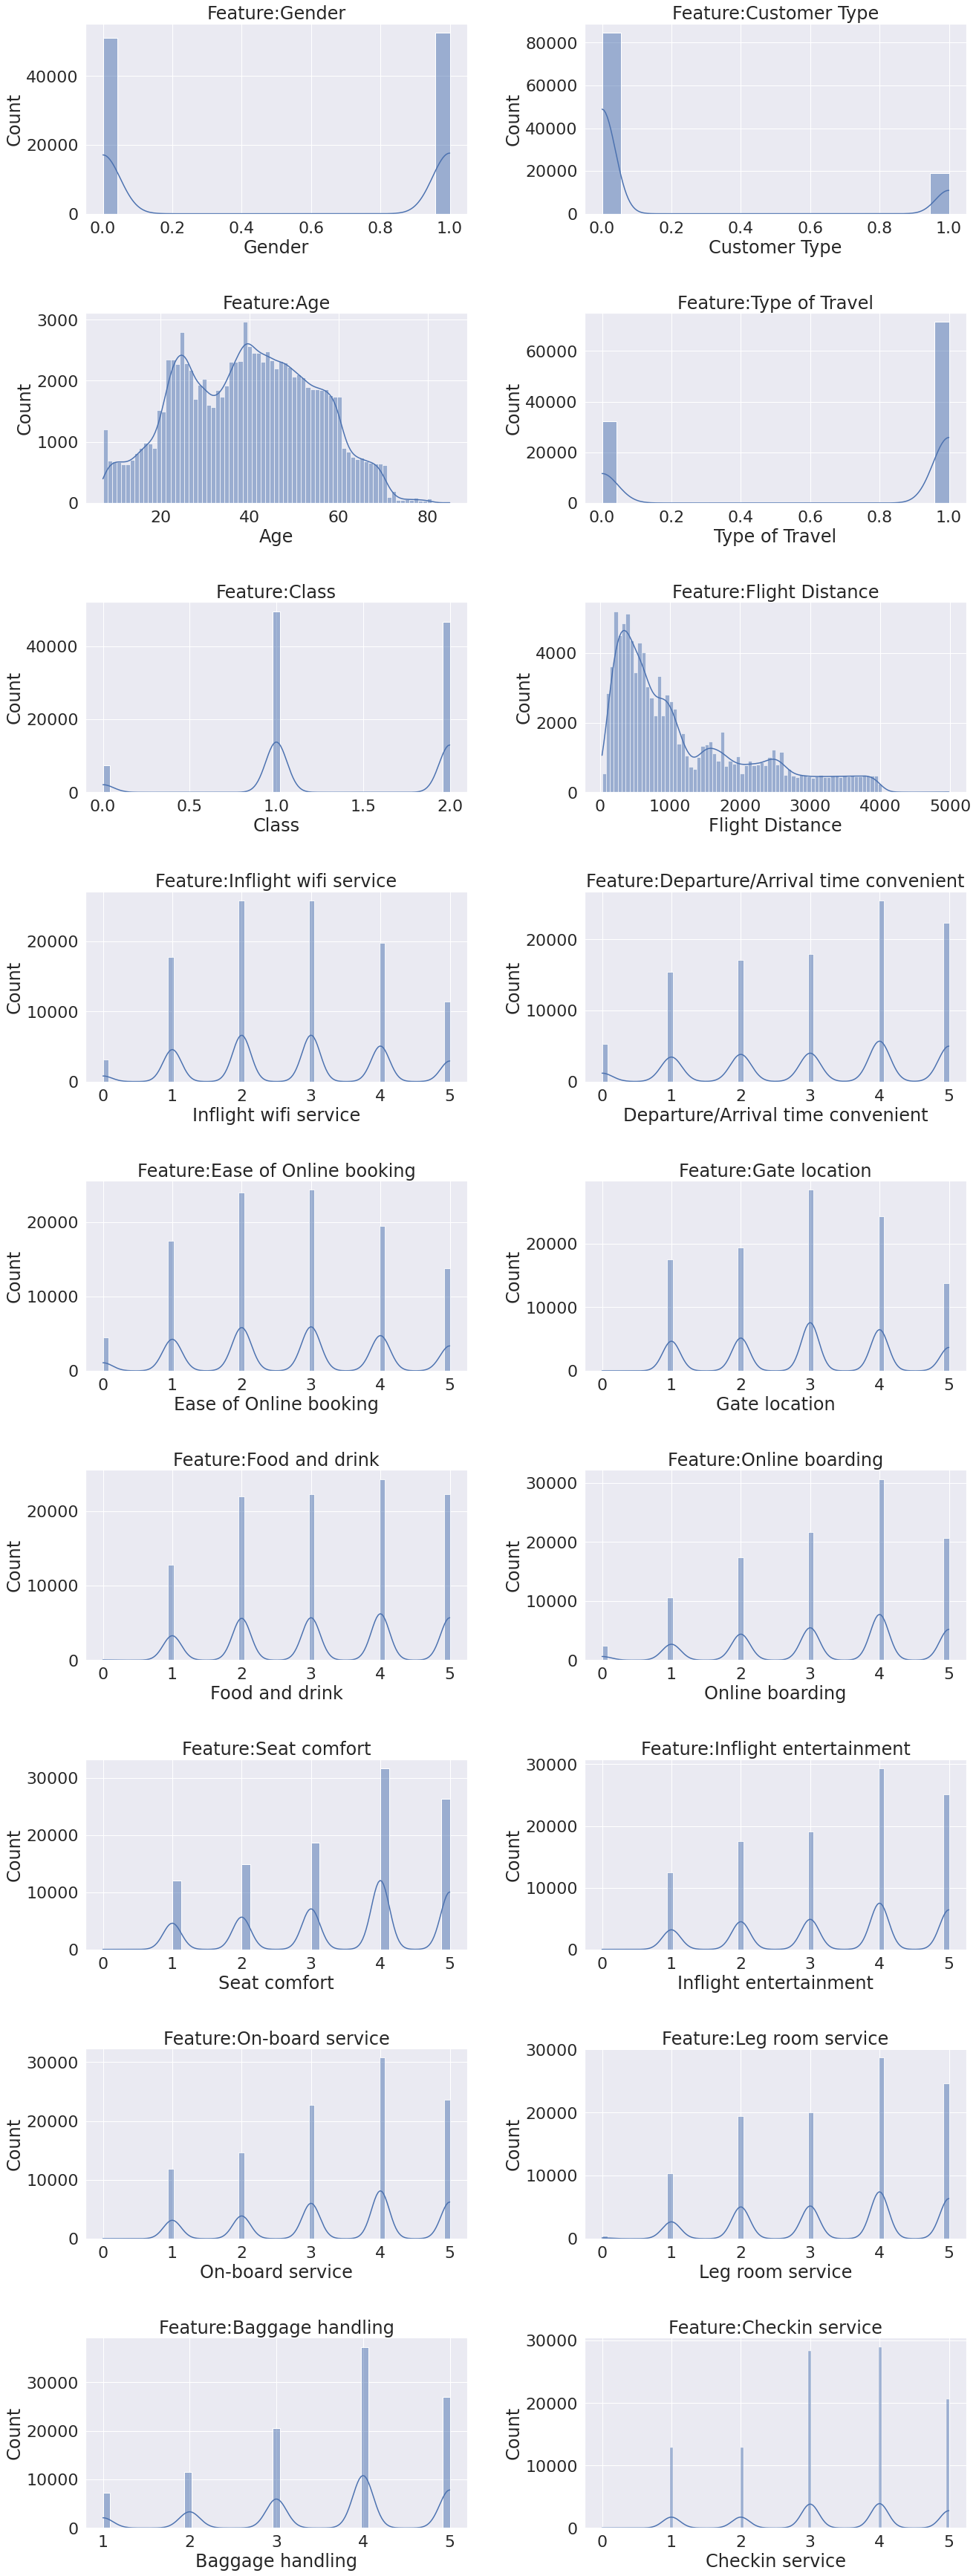

In [33]:
import seaborn as sns
numerics = ['int64','float64']

train_con_col = df_train.select_dtypes(include = numerics).columns
train_cat_col = df_train.select_dtypes(include = "object").columns
test_con_col = df_test.select_dtypes(include = numerics).columns
test_cat_col = df_test.select_dtypes(include = "object").columns

fig, axs = plt.subplots(9, 2, figsize=(20,50))
fig.tight_layout(pad=4.0)

for f,ax in zip(train_con_col,axs.ravel()):
    sns.set(font_scale = 2)
    ax=sns.histplot(ax=ax,data=df_train,x=df_train[f],kde=True)
    ax.set_title('Feature:'+ f)

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time

kernels = ['linear', 'poly','rbf', 'sigmoid']
svms = {}

for kernel in kernels:
  start = time.time()
  clf = SVC(kernel=kernel)
  clf.fit(x_train, df_train_y)
  # saving each classifier in a dict with kernel as its key
  svms[kernel] = clf
  y_pred = clf.predict(x_test)
  end = time.time()
  print(confusion_matrix(df_test_y, y_pred))
  print(classification_report(df_test_y, y_pred))
  print(accuracy_score(df_test_y, y_pred))
  print(f"execution time: {end - start} seconds")
  print()


[[13279  1249]
 [ 2057  9308]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14528
           1       0.88      0.82      0.85     11365

    accuracy                           0.87     25893
   macro avg       0.87      0.87      0.87     25893
weighted avg       0.87      0.87      0.87     25893

0.8723207044374928
execution time: 999.894772529602 seconds

[[13920   608]
 [  961 10404]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14528
           1       0.94      0.92      0.93     11365

    accuracy                           0.94     25893
   macro avg       0.94      0.94      0.94     25893
weighted avg       0.94      0.94      0.94     25893

0.9394044722511876
execution time: 241.31668734550476 seconds

[[14084   444]
 [  738 10627]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14528
           1       0

Replicating a homework question on this data regarding gridsearchCV and random forests.

In [35]:
# The paramater values are only suggestive. You can come up with better choices.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
# Number of features to consider at every split
max_features = [5,10, 20]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8] #, 11, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4] #, 6, 8]

# Run GridSearch to tune the hyper-parameter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

k_fold_cv = 2
grid_params = {
 'n_estimators' : n_estimators,
 'max_features' : max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf
}

Evaluating gridsearch results.


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_train = df_train_y

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, grid_params, verbose=2, cv=2, n_jobs = 4)
grid_search.fit(x_train, y_train)

y_test = df_test_y
y_pred = grid_search.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"{grid_search.best_params_}")
print(f"{grid_search.best_estimator_.feature_importances_}")




Fitting 2 folds for each of 243 candidates, totalling 486 fits
[[14231   297]
 [  627 10738]]
0.9643146796431468
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14528
           1       0.97      0.94      0.96     11365

    accuracy                           0.96     25893
   macro avg       0.97      0.96      0.96     25893
weighted avg       0.96      0.96      0.96     25893

{'max_depth': 55, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
[0.00166774 0.03956343 0.02250529 0.11421321 0.08222881 0.02236391
 0.161989   0.00842958 0.02656109 0.01138013 0.00644607 0.27474925
 0.026276   0.06484355 0.0174724  0.02828432 0.01969428 0.02102616
 0.01898775 0.01613498 0.00665645 0.0085266 ]


# New Section

In [39]:
important_features = []
for feature in zip(df_test_x.columns, grid_search.best_estimator_.feature_importances_):
  important_features.append(feature)


important_features.sort(key=lambda x: x[1], reverse=True)
print(important_features)


train_frame2 = df_train_x[['Online boarding', 'Inflight wifi service']]
test_frame2 = df_test_x[['Online boarding', 'Inflight wifi service']]

train_frame3 = df_train_x[['Online boarding', 'Inflight wifi service', 'Type of Travel']]
test_frame3 = df_test_x[['Online boarding', 'Inflight wifi service', 'Type of Travel']]

clf2 = SVC(kernel='rbf')
clf2.fit(train_frame2, y_train)
y_pred2 = clf2.predict(test_frame2)
print(accuracy_score(y_test, y_pred2))

clf3 = SVC(kernel='rbf')
clf3.fit(train_frame3, y_train)
y_pred3 = clf3.predict(test_frame3)
print(accuracy_score(y_test, y_pred3))


[('Online boarding', 0.27474925056226895), ('Inflight wifi service', 0.1619890009407661), ('Type of Travel', 0.11421320798560264), ('Class', 0.08222881419435273), ('Inflight entertainment', 0.06484354634686247), ('Customer Type', 0.03956342657592963), ('Leg room service', 0.028284319826696765), ('Ease of Online booking', 0.02656108655167165), ('Seat comfort', 0.026275998338058607), ('Age', 0.022505290258379003), ('Flight Distance', 0.022363908483722734), ('Checkin service', 0.02102615646218972), ('Baggage handling', 0.019694279091563675), ('Inflight service', 0.018987750700865648), ('On-board service', 0.017472403226146276), ('Cleanliness', 0.016134978570487322), ('Gate location', 0.011380133558266793), ('Arrival Delay in Minutes', 0.008526601550530153), ('Departure/Arrival time convenient', 0.008429576206948886), ('Departure Delay in Minutes', 0.006656452176602044), ('Food and drink', 0.0064460743375791005), ('Gender', 0.001667744054509097)]
0.8177885915112193
0.8896612984204225
